In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('text', usetex = True)
# mpl.rc('font', family = 'serif')
import cPickle as cp
import sys
sys.path.append("../../utils")
from misc_utils import expected_loss
import os
from copy import deepcopy
from plotting_performance_vs_metric import get_closeness, get_log_closeness, get_spectrum
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array
from plotting_performance_vs_metric import get_nystrom_memory_with_model, get_rff_memory_with_model, get_cir_rff_memory_with_model
from plotting_performance_vs_metric import plot_figure, save_csv_with_error_bar
import math
from plot_utils import get_colors

### plot performance v.s. approximation error

In [2]:
def get_results_for_one_precision(n_rff_feat, general_folder_measurement,
                                  general_folder_performance, general_folder_delta, general_folder_norm,
                                  folder_pattern, seeds=[1,], min_best=True, y_reverse=False):
    f_norm_list_rff = []
    s_norm_list_rff = []
    l2_loss_list_rff = []
    delta_list_rff = []

    for seed in seeds:
        f_norm_list = []
        l2_loss_list = []
        delta_list = []
        s_norm_list = []
        for n_feat in n_rff_feat:
            subfolder_name = deepcopy(folder_pattern)
            if "n_fp_feat_unk" in subfolder_name:
                subfolder_name = subfolder_name.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
            else:
                subfolder_name = subfolder_name.replace("n_feat_unk", "n_feat_" + str(n_feat) )
            subfolder_name = subfolder_name.replace("seed_unk", "seed_" + str(seed) )
            folder_name = general_folder_performance + "/" + subfolder_name
            file_name = "eval_metric.txt"
            l2_loss = get_performance_metric(folder_name, file_name, min_best=min_best)
            l2_loss_list.append(l2_loss)

            folder_name = general_folder_delta + "/" + subfolder_name
            if not os.path.exists(folder_name):
                folder_name = folder_name.replace("_opt_sgd_lr_10_", "_")
            file_name = "metric_sample_eval_py2.txt"
            if not os.path.isfile(folder_name + "/" + file_name):
                file_name = "metric_sample_eval.txt"
            metric_name = "Delta"
            delta = get_measurement_metric(folder_name, file_name, metric_name)
            delta_list.append(delta)

            file_name = "metric_sample_eval_py2.txt"
            if not os.path.exists(folder_name):
                folder_name = folder_name.replace("_opt_sgd_lr_10_", "_")
            if not os.path.isfile(folder_name + "/" + file_name):
                file_name = "metric_sample_eval.txt"
            metric_name = "F_norm_error"
            f_norm_error = get_measurement_metric(folder_name, file_name, metric_name)
            f_norm_list.append(f_norm_error)
            
            folder_name = general_folder_norm + "/" + subfolder_name
            file_name = "metric_sample_eval_py2.txt"
            if not os.path.isfile(folder_name + "/" + file_name):
                file_name = "metric_sample_eval.txt"
            metric_name = "spectral_norm_error"
            s_norm_error = get_measurement_metric(folder_name, file_name, metric_name)
            s_norm_list.append(s_norm_error)

        f_norm_list_rff.append(np.array(deepcopy(f_norm_list) ) )
        s_norm_list_rff.append(np.array(deepcopy(s_norm_list) ) )
        l2_loss_list_rff.append(1.0 - np.array(deepcopy(l2_loss_list) ) )
        delta_list_rff.append(np.array(deepcopy(delta_list) ) )

#     f_norm_list_rff = average_results_array(f_norm_list_rff)
#     l2_loss_list_rff = average_results_array(l2_loss_list_rff)
#     delta_list_rff = average_results_array(delta_list_rff)
#     memory_list_rff = np.array( [rff_mem_func(n_feat) for n_feat in n_rff_feat] )
    return f_norm_list_rff, l2_loss_list_rff, delta_list_rff, s_norm_list_rff#, memory_list_rff

In [3]:
EPS = 1e-20

In [4]:
n_rff_feat_dict = {64: [200, 500, 1000, 2000, 5000, 10000, 20000, ],
           16: [500, 1000, 2000, 5000, 10000, 20000 , ],
           8: [1000, 2000, 5000, 10000, 20000, ],
           4: [1000, 2000, 5000, 10000, 20000, ],
           2: [1000, 2000, 5000, 10000, 20000, ],
           1: [1000, 2000, 5000, 10000, 20000, ], }

m = 250
r = 54
# get results from cir rff runs
f_norm_list_cir_rff = {}
s_norm_list_cir_rff = {}
l2_loss_list_cir_rff = {}
delta_list_cir_rff = {}
memory_list_cir_rff = {}
general_folder_norm = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification_heldout_spectral_norm"
for nbit in [64, 16, 8, 4, 2, 1]:
    if nbit == 64:
        rff_mem_func = lambda n : get_cir_rff_memory_with_model(n, m, r, 32, c=1)
    else:
        rff_mem_func = lambda n : get_cir_rff_memory_with_model(n, m, r, nbit, c=1)

    n_rff_feat = n_rff_feat_dict[nbit]
    general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
    general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
    general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification_delta"
    folder_pattern = "covtype_type_cir_rff_l2_reg_1e-05_n_feat_unk_n_bit_" + str(nbit) + "_opt_sgd_lr_10_seed_unk"
#     folder_pattern = "census_type_cir_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(nbit) + "_seed_unk"
    f_norm_list, l2_loss_list, delta_list, s_norm_list = \
        get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                      general_folder_performance, general_folder_delta, general_folder_norm,
                                      folder_pattern=folder_pattern, seeds=[1,2,3,4,5], 
                                      min_best=False, y_reverse=True)
    memory_list = [rff_mem_func(x) for x in n_rff_feat]
    f_norm_list_cir_rff[nbit] = deepcopy(f_norm_list)
    s_norm_list_cir_rff[nbit] = deepcopy(s_norm_list)
    l2_loss_list_cir_rff[nbit] = deepcopy(l2_loss_list)
    delta_list_cir_rff[nbit] = deepcopy(delta_list)
    memory_list_cir_rff[nbit] = deepcopy(memory_list)
    
# get results from fp nystrom runs
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c=2)
n_nystrom_feat = [1250, 2500, 5000, 10000, 20000]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/closeness/classification_real_setting"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/closeness/classification_real_setting"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/symmetric_delta/classification_real_setting"
folder_pattern = "covtype_with_metric_type_nystrom_l2_reg_1e-05_n_fp_feat_unk_opt_sgd_lr_10_seed_unk"
f_norm_list_nystrom, l2_loss_list_nystrom, delta_list_nystrom, s_norm_list_nystrom = \
    get_results_for_one_precision(n_nystrom_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta, general_folder_norm,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,4,5], 
                                  min_best=False, y_reverse=True)
memory_list_nystrom = [nystrom_mem_func(x) for x in n_nystrom_feat]
    
# get results from basic rff runs
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c=2)
n_rff_feat = n_rff_feat_dict[64]
general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification"
general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/lp_rff/real_classification_delta"
# folder_pattern = "census_type_rff_l2_reg_0.0005_n_feat_unk_n_bit_" + str(64) + "_seed_unk"
folder_pattern = "covtype_type_rff_l2_reg_1e-05_n_feat_unk_n_bit_" + str(64) + "_opt_sgd_lr_10_seed_unk"
f_norm_list_rff, l2_loss_list_rff, delta_list_rff, s_norm_list_rff = \
    get_results_for_one_precision(n_rff_feat, general_folder_measurement, 
                                  general_folder_performance, general_folder_delta, general_folder_norm,
                                  folder_pattern=folder_pattern, seeds=[1,2,3,4,5], 
                                  min_best=False, y_reverse=True)
memory_list_rff = [rff_mem_func(x) for x in n_rff_feat]        


def plot_all(plot_all_line=False):
    if plot_all_line:
        bit_list = [8, 4, 1]
    else:
        bit_list = [8, 4, ]
    plt.figure()
    data_list = []
    data_list.append(("FP-Nystrom", memory_list_nystrom, l2_loss_list_nystrom) )
    data_list.append(("FP-RFF", memory_list_rff, l2_loss_list_rff) )
    if plot_all_line:
        data_list.append(("Cir. FP-RFF", memory_list_cir_rff[64], l2_loss_list_cir_rff[64] ) )
    for nbit in bit_list:
        data_list.append(("LP-RFF " + str(nbit), memory_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict)
    plt.xscale("log")
    plt.ylabel("Heldout error", fontsize=16)
    plt.xlabel("Memory budget", fontsize=16)
    # plt.title("acc vs memory")
    plt.legend(fontsize=16, framealpha=0.3)
    plt.tight_layout()
    if plot_all_line:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_mem_all_line.csv")
        plt.savefig("./figures/classification_acc_vs_mem_all_line.pdf")
    else:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_mem.csv")
        plt.savefig("./figures/classification_acc_vs_mem.pdf")
    plt.show()
    # plt.ylim([None, 2e8])
    plt.show()        

    plt.figure()
    data_list = []
    data_list.append(("FP-Nystrom", memory_list_nystrom, delta_list_nystrom) )
    data_list.append(("FP-RFF", memory_list_rff, delta_list_rff) )
    if plot_all_line:
        data_list.append(("Cir. FP-RFF", memory_list_cir_rff[64], delta_list_cir_rff[64] ) )
    for nbit in bit_list:
        data_list.append(("LP-RFF " + str(nbit), memory_list_cir_rff[nbit], delta_list_cir_rff[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("\lambda-spectral distance", fontsize=16)
    plt.xlabel("Memory budget", fontsize=16)
    # plt.title("delta vs memory")
    plt.legend(fontsize=16, framealpha=0.3, loc="lower left")
    plt.tight_layout()
    if plot_all_line:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_delta_vs_mem_all_line.csv")
        plt.savefig("./figures/classification_delta_vs_mem_all_line.pdf")
    else:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_delta_vs_mem.csv")
        plt.savefig("./figures/classification_delta_vs_mem.pdf")
    plt.show()
    # plt.ylim([None, 2e8])
    plt.show()

    plt.figure()
    data_list = []
    data_list.append(("FP-Nystrom", delta_list_nystrom, l2_loss_list_nystrom) )
    data_list.append(("FP-RFF", delta_list_rff, l2_loss_list_rff) )
    if plot_all_line:
        data_list.append(("Cir. FP-RFF", delta_list_cir_rff[64], l2_loss_list_cir_rff[64] ) )
    for nbit in bit_list:
        data_list.append(("LP-RFF " + str(nbit), delta_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict, ave_x=True)
    plt.xscale("log")
    plt.ylabel("Heldout error", fontsize=16)
    plt.xlabel("\lambda-spectral distance", fontsize=16)
    # plt.title("acc vs delta")
    plt.legend(fontsize=16)
    plt.tight_layout()
    if plot_all_line:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_delta_all_line.csv")
        plt.savefig("./figures/classification_acc_vs_delta_all_line.pdf")
    else:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_delta.csv")
        plt.savefig("./figures/classification_acc_vs_delta.pdf")
    plt.show()
    # plt.ylim([None, 2e8])
    plt.show()

    plt.figure()
    data_list = []
    data_list.append(("FP-Nystrom", f_norm_list_nystrom, l2_loss_list_nystrom) )
    data_list.append(("FP-RFF", f_norm_list_rff, l2_loss_list_rff) )
    if plot_all_line:
        data_list.append(("Cir. FP-RFF", f_norm_list_cir_rff[64], l2_loss_list_cir_rff[64] ) )
    for nbit in bit_list:
        data_list.append(("LP-RFF " + str(nbit), f_norm_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict, ave_x=True)
    plt.xscale("log")
    plt.ylabel("Heldout error", fontsize=16)
    plt.xlabel("Frobenius norm", fontsize=16)
    # plt.title("acc vs delta")
    plt.legend(fontsize=16)
    plt.tight_layout()
    if plot_all_line:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_f_norm_all_line.csv")
        plt.savefig("./figures/classification_acc_vs_f_norm_all_line.pdf")
    else:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_f_norm.csv")
        plt.savefig("./figures/classification_acc_vs_f_norm.pdf")
    plt.show()
    # plt.ylim([None, 2e8])
    plt.show()

    plt.figure()
    data_list = []
    data_list.append(("FP-Nystrom", s_norm_list_nystrom, l2_loss_list_nystrom) )
    data_list.append(("FP-RFF", s_norm_list_rff, l2_loss_list_rff) )
    if plot_all_line:
        data_list.append(("Cir. FP-RFF", s_norm_list_cir_rff[64], l2_loss_list_cir_rff[64] ) )
    for nbit in bit_list:
        data_list.append(("LP-RFF " + str(nbit), s_norm_list_cir_rff[nbit], l2_loss_list_cir_rff[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict, ave_x=True)
    plt.xscale("log")
    plt.ylabel("Heldout error", fontsize=16)
    plt.xlabel("s norm", fontsize=16)
    # plt.title("acc vs delta")
    plt.legend(fontsize=16)
    plt.tight_layout()
    if plot_all_line:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_s_norm_all_line.csv")
        plt.savefig("./figures/classification_acc_vs_s_norm_all_line.pdf")
    else:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/classification_acc_vs_s_norm.csv")
        plt.savefig("./figures/classification_acc_vs_s_norm.pdf")
    plt.show()
    # plt.ylim([None, 2e8])
    plt.show()

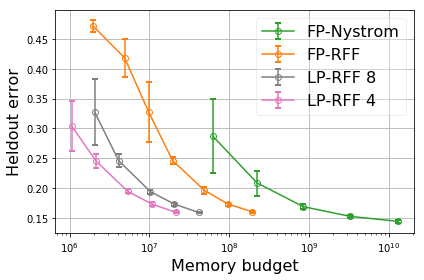

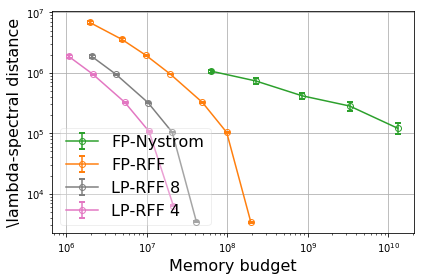

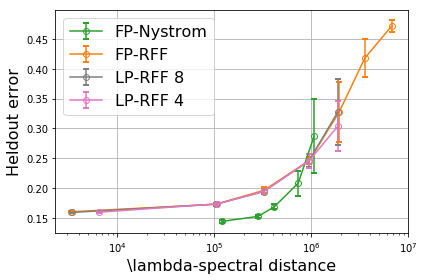

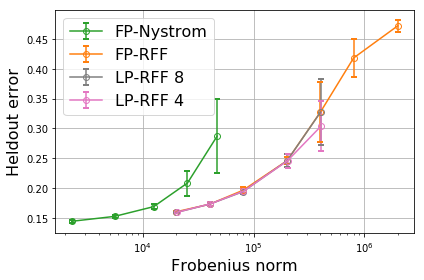

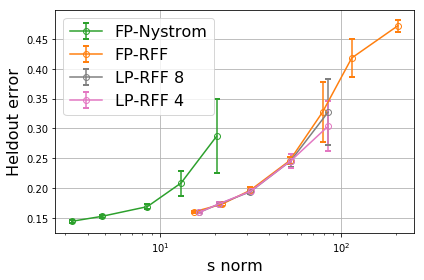

In [5]:
plot_all(plot_all_line=False)

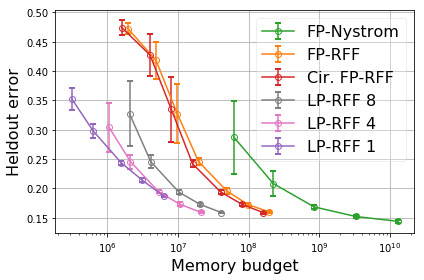

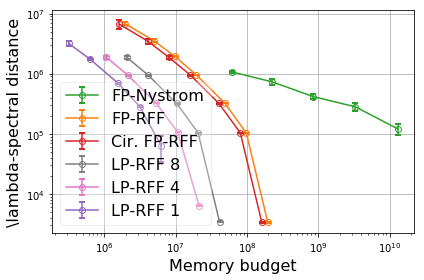

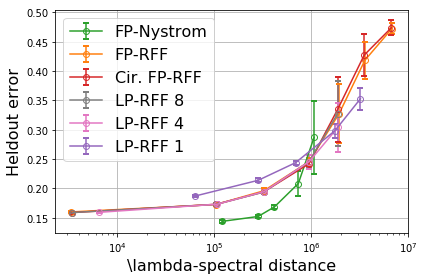

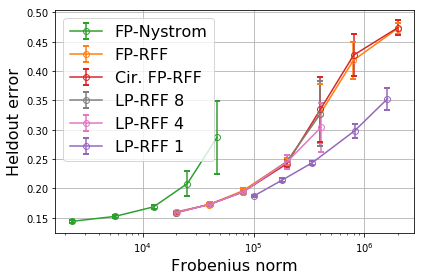

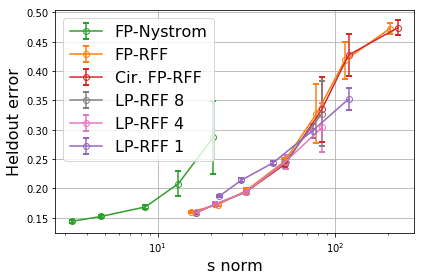

In [6]:
plot_all(plot_all_line=True)